# OWL-ViT minimal example

This Colab shows how to **load a pre-trained OWL-ViT checkpoint** and use it to
**get object detection predictions** for an image.

# Download and install OWL-ViT

OWL-ViT is implemented in [Scenic](https://github.com/google-research/scenic). The cell below installs the Scenic codebase from GitHub and imports it.

In [1]:
!rm -rf *
!rm -rf .config
!rm -rf .git
!git clone https://github.com/google-research/scenic.git .
!python -m pip install -q .
!python -m pip install -r ./scenic/projects/owl_vit/requirements.txt

# Also install big_vision, which is needed for the mask head:
!mkdir /big_vision
!git clone https://github.com/google-research/big_vision.git /big_vision
!python -m pip install -r /big_vision/big_vision/requirements.txt
import sys
sys.path.append('/big_vision/')
!echo "Done."

Cloning into '.'...
remote: Enumerating objects: 9291, done.
remote: Counting objects: 100% (1309/1309), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 9291 (delta 1133), reused 1064 (delta 1064), pack-reused 7982 (from 4)
Receiving objects: 100% (9291/9291), 65.03 MiB | 18.52 MiB/s, done.
Resolving deltas: 100% (6552/6552), done.
Updating files: 100% (1066/1066), done.
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7ij2gzq5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7ij2gzq5
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-0edxagnn
  Running c

In [5]:
!pip install ott-jax==0.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: ott-jax
    Found existing installation: ott-jax 0.3.1
    Uninstalling ott-jax-0.3.1:
      Successfully uninstalled ott-jax-0.3.1


In [6]:
import os

import jax
from matplotlib import pyplot as plt
import numpy as np
from scenic.projects.owl_vit import configs
from scenic.projects.owl_vit import models
from scipy.special import expit as sigmoid
import skimage
from skimage import io as skimage_io
from skimage import transform as skimage_transform

# Choose config

In [7]:
config = configs.owl_v2_clip_b16.get_config(init_mode='canonical_checkpoint')

# Load the model and variables

In [8]:
module = models.TextZeroShotDetectionModule(
    body_configs=config.model.body,
    objectness_head_configs=config.model.objectness_head,
    normalize=config.model.normalize,
    box_bias=config.model.box_bias)

In [9]:
variables = module.load_variables(config.init_from.checkpoint_path)

# 准备图片

In [23]:
filename = '/content/thread.png'
image_uint8 = skimage_io.imread(filename)
image = image_uint8.astype(np.float32) / 255.0

# Pad to square with gray pixels on bottom and right:
h, w, _ = image.shape
size = max(h, w)
image_padded = np.pad(
    image, ((0, size - h), (0, size - w), (0, 0)), constant_values=0.5)

# Resize to model input size:
input_image = skimage.transform.resize(
    image_padded,
    (config.dataset_configs.input_size, config.dataset_configs.input_size),
    anti_aliasing=True)

# 准备文本提示词

In [30]:
text_queries = ['thread', 'defect', 'cloth', 'a thread']
tokenized_queries = np.array([
    module.tokenize(q, config.dataset_configs.max_query_length)
    for q in text_queries
])

# Pad tokenized queries to avoid recompilation if number of queries changes:
tokenized_queries = np.pad(
    tokenized_queries,
    pad_width=((0, 100 - len(text_queries)), (0, 0)),
    constant_values=0)

# 获得预测结果

In [31]:
jitted = jax.jit(module.apply, static_argnames=('train',))

In [32]:
# Note: The model expects a batch dimension.
predictions = jitted(
    variables,
    input_image[None, ...],
    tokenized_queries[None, ...],
    train=False)

# Remove batch dimension and convert to numpy:
predictions = jax.tree_util.tree_map(lambda x: np.array(x[0]), predictions )

# Plot predictions

In [33]:
%matplotlib inline

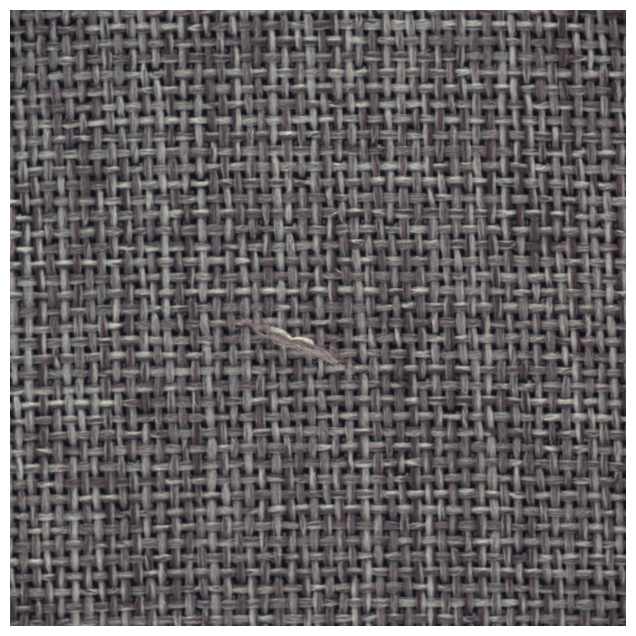

In [34]:
score_threshold = 0.2

logits = predictions['pred_logits'][..., :len(text_queries)]  # Remove padding.
scores = sigmoid(np.max(logits, axis=-1))
labels = np.argmax(predictions['pred_logits'], axis=-1)
boxes = predictions['pred_boxes']

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(input_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

for score, box, label in zip(scores, boxes, labels):
  if score < score_threshold:
    continue
  cx, cy, w, h = box
  ax.plot([cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
          [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2], 'r')
  ax.text(
      cx - w / 2,
      cy + h / 2 + 0.015,
      f'{text_queries[label]}: {score:1.2f}',
      ha='left',
      va='top',
      color='red',
      bbox={
          'facecolor': 'white',
          'edgecolor': 'red',
          'boxstyle': 'square,pad=.3'
      })

## Plot objectness

Text(0.5, 1.0, 'Top 20 objects by objectness')

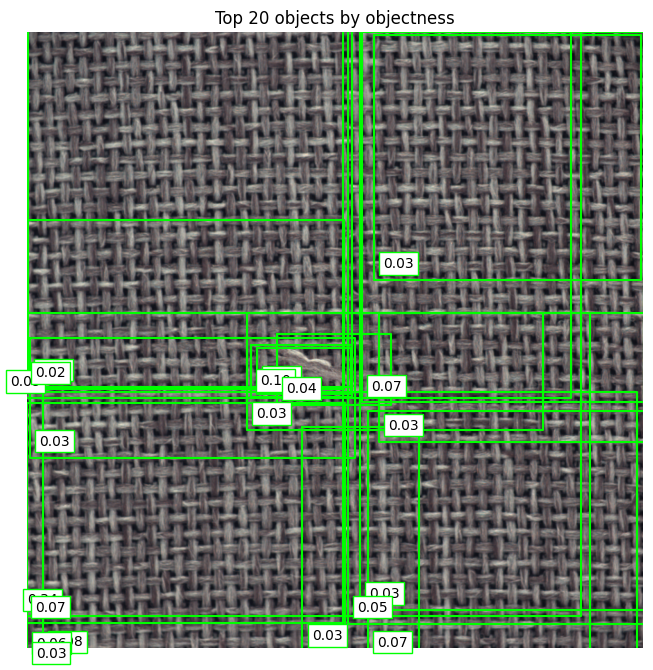

In [35]:
top_k = 20
objectnesses = sigmoid(predictions['objectness_logits'])
boxes = predictions['pred_boxes']

objectness_threshold = np.partition(objectnesses, -top_k)[-top_k]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(input_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

for box, objectness in zip(boxes, objectnesses):
  if objectness < objectness_threshold:
    continue

  cx, cy, w, h = box
  ax.plot([cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
          [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2],
          color='lime')

  ax.text(
    cx - w / 2 + 0.015,
    cy + h / 2 - 0.015,
    f'{objectness:1.2f}',
    ha='left',
    va='bottom',
    color='black',
    bbox={
        'facecolor': 'white',
        'edgecolor': 'lime',
        'boxstyle': 'square,pad=.3'
    })

ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
ax.set_title(f'Top {top_k} objects by objectness')